https://github.com/jwilsson/spotify-web-api-php/blob/main/docs/examples/working-with-scopes.md
https://docs.google.com/document/d/1Fy9aKwfZ1OY6RmsmPCBHVnkZGVKqVPyaYz9ScJlVb6U/edit

# Authorization & Set-up

In [1]:
import time
import os
import requests
import base64
from dotenv import load_dotenv
import json
from urllib.parse import urlencode
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import random
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn

from bokeh.plotting import figure, show, output_notebook, ColumnDataSource
from bokeh.models import HoverTool, Div
from bokeh.layouts import column
from bokeh.io import curdoc

In [2]:
AUTH_URL = 'https://accounts.spotify.com/api/token'
BASE_URL = 'https://api.spotify.com/v1/'

In [3]:
def getAuth():
    # Retrieve client ID & secret from env file & encode.
    dotenv_path = '/Users/keegankelly/NYU/Classes/Advanced_Python/project/advanced_python/advanced_python.env'
    #/Users/mariam/Documents/GitHub/advanced_python/credentials.env' # Put your credentials in.
    load_dotenv(dotenv_path=dotenv_path)  # Use the path for dotenv
    client_id, client_secret = os.environ.get('client_id'), os.environ.get('client_secret') #verify var names.
    credentials = f"{client_id}:{client_secret}"
    credentials_b64 = base64.b64encode(credentials.encode())
    
    url = 'https://accounts.spotify.com/api/token'
    token_data = {'grant_type': 'client_credentials'}
    headers = {
        'Content-Type': 'application/x-www-form-urlencoded',
        'Authorization': f'Basic {credentials_b64.decode()}'
    }
    
    response = requests.post(url, data=token_data, headers=headers)
    if response.ok:
        return response.json().get('access_token')
    else:
        print(f"Invalid: {response.status_code}, {response.text}")
        return None

# Playlist(S)

In [4]:
def getPlaylists(access_token):
    user_id = os.environ.get('user_id')
    headers = {
        "Authorization": f"Bearer {access_token}"
    }
    response = requests.get(f"{BASE_URL}users/{user_id}/playlists", headers=headers)
    if response.ok:
        return response.json()
    else:
        print(f"Invalid: {response.status_code}, {response.text}")
    return None

def dfPlaylists(user_playlists_json):
    df_playlists = pd.json_normalize(user_playlists_json['items'], sep = '_', record_prefix = 'playlist_', errors = 'ignore')
    return df_playlists

def getColumns(df_playlists, relevant_columns):
    cleaned_columns = [col for col in relevant_columns if col in df_playlists.columns]
    return df_playlists[cleaned_columns]

In [5]:
def getPlaylist(playlist_id, access_token):
    headers = {
        "Authorization": f"Bearer {access_token}"
    }
    
    all_tracks = []
    response = requests.get(f"{BASE_URL}playlists/{playlist_id}/tracks?limit=100", headers=headers)
    if response.ok:
        data = response.json()
        all_tracks.extend(data['items'])  
        
        while data['next']:
            response = requests.get(data['next'], headers=headers) #Use the 'next' URL provided by the API? Or manual?
            if response.ok:
                data = response.json()
                all_tracks.extend(data['items'])  
            else:
                print(f"Invalid: {response.status_code}, {response.text}")
                break  

        return all_tracks
    else:
        print(f"Invalid: {response.status_code}, {response.text}")
        return None

def dfPlaylist(tracks_json):
    tracks = []
    for item in tracks_json:
        track = item.get('track', {})
        if track:  
            track_info = {
                'id': track.get('id'),
                'title': track.get('name'),
                'popularity': track.get('popularity'),
                'album': track['album'].get('name'),
                'release_date': track['album'].get('release_date'),
                'album_total_tracks': track['album'].get('total_tracks'),
                'artist': ', '.join([artist['name'] for artist in track['artists']]), 
                'artist_id': track['artists'][0]['id'] if track['artists'] else None,  
                'album_id': track['album'].get('id')
            }
            tracks.append(track_info)
    
    df_tracks = pd.DataFrame(tracks)
    return df_tracks

# Audio Features

In [6]:
def getAudiosFeatures(track_ids, access_token):
    MAX_TRACKS = 100
    all_features = []  
    
    headers = {
        "Authorization": f"Bearer {access_token}"
    }
    for i in range(0, len(track_ids), MAX_TRACKS):
        chunk = track_ids[i:i+MAX_TRACKS]
        track_ids_str = ",".join(chunk)

        response = requests.get(f"{BASE_URL}audio-features?ids={track_ids_str}", headers=headers)
        if response.ok:
            data = response.json()
            all_features.extend(data['audio_features'])
        else:
            print(f"Invalid: {response.status_code}, {response.text}")
            return None  

    return all_features

def genretoPlaylist(df_tracks, df_artists): #Determine how to flow this.
    df_tmp_genre = pd.Series(df_artists.set_index('id')['genres'].to_dict())
    df_tracks['genres'] = df_tracks['artist_id'].map(df_tmp_genre)
    return df_tracks

def audioFeaturesDf(audio_features_json): 
    features_list = audio_features_json['audio_features'] if 'audio_features' in audio_features_json else audio_features_json
    
    features_data = []
    for feature in features_list:
        if feature:  
            features = {
                'danceability': feature['danceability'],
                'energy': feature['energy'],
                'key': feature['key'],
                'loudness': feature['loudness'],
                'mode': feature['mode'],
                'speechiness': feature['speechiness'],
                'acousticness': feature['acousticness'],
                'instrumentalness': feature['instrumentalness'],
                'liveness': feature['liveness'],
                'valence': feature['valence'],
                'tempo': feature['tempo'],
                'duration_ms': feature['duration_ms'],
                'time_signature': feature['time_signature']
            }

            if 'id' in feature:
                features['id'] = feature['id']
            features_data.append(features)
    
    df_features = pd.DataFrame(features_data)
    if 'id' in df_features.columns:
        df_features.set_index('id', inplace=True)
    return df_features

# Artists

In [7]:
def getArtist(artist_ids, access_token):
    MAX_IDS = 50
    artists_info = {'artists': []}
    
    unique_artist_ids = list(set(artist_ids))
    
    for i in range(0, len(unique_artist_ids), MAX_IDS):
        chunk = unique_artist_ids[i:i+MAX_IDS]
        artist_ids_str = ",".join(chunk)
        
        headers = {"Authorization": f"Bearer {access_token}"}
        response = requests.get(f"{BASE_URL}artists?ids={artist_ids_str}", headers=headers)
        
        if response.ok:
            chunk_data = response.json()
            artists_info['artists'].extend(chunk_data['artists'])
        else:
            print(f"Invalid: {response.status_code}, {response.text}")
    
    return artists_info

def artistDf(artist_json):
    artists = []
    for artist in artist_json['artists']:
        artist_info = {
            'followers': artist['followers']['total'],
            'genres': artist['genres'],  
            'id': artist['id'],
            'name': artist['name'],
            'popularity': artist['popularity']
        }
        artists.append(artist_info)
    df_artists = pd.DataFrame(artists)
    return df_artists

In [8]:
def getRelatedArtists(access_token, artist_id):
    user_id = os.environ.get('user_id')
    headers = {
        "Authorization": f"Bearer {access_token}"
    }
    
    response = requests.get(f"{BASE_URL}artists/{artist_id}/related-artists", headers=headers)
    if response.ok:
        return response.json()
    else:
        print(f"Invalid: {response.status_code}, {response.text}")
    return None


def relatedDf(related_json):
    related = []
    if 'artists' in related_json:
        for artist in related_json['artists']:
            artist_dict = {
                'Name': artist['name'],
                'Genres': ', '.join(artist['genres']) if artist['genres'] else 'N/A',  
                'Followers': artist['followers']['total'],
                'Popularity': artist['popularity'],
            }
            related.append(artist_dict)
    df_related = pd.DataFrame(related)
    return df_related

# Testing & Data Set-up

In [9]:
# Select playlist to analyze.

t = time.process_time()
access_token = getAuth()
user_playlists = getPlaylists(access_token)
tmp_df = dfPlaylists(user_playlists)
playlists_original_df = getColumns(tmp_df,['id','name', 'tracks_total'])
elapsed_time = time.process_time() - t
print('Time elapsed:', elapsed_time,'s')

playlists_original_df.head(20)

Time elapsed: 0.05901199999999962 s


,id,name,tracks_total
0,7qkgBK0HyIl7KGA0Z0wK7F,Adv_Python,3


In [10]:
# See track details from indicated playlist.

t = time.process_time()
playlist = getPlaylist('1yAVZk9EiKCBkdndqpUDXk', access_token)
df_tracks = dfPlaylist(playlist)
elapsed_time = time.process_time() - t
print('Time elapsed:', elapsed_time,'s')

df_tracks.head(20) 

Time elapsed: 0.17700700000000014 s


,id,title,popularity,album,release_date,album_total_tracks,artist,artist_id,album_id
0,33CehYfkie4ugV2gWaTKlM,Sleep Alone,0,Beacon (Deluxe Version),2012-01-01,25,Two Door Cinema Club,536BYVgOnRky0xjsPT96zl,3Mdzwty8ag5QyAYLxThypm
1,3EbDjzynYszfKEbCzQLA22,Hyperlips,0,Galactic Melt,2011-06-14,11,Com Truise,2wouN3QXejYa5tKetYdcVX,3r3xMNOAv4zAlevfVhbWHX
2,4iG2gAwKXsOcijVaVXzRPW,Time to Pretend,80,Oracular Spectacular,2007-12-14,10,MGMT,0SwO7SWeDHJijQ3XNS7xEE,6mm1Skz3JE6AXneya9Nyiv
3,0MVE8I80hHgzidIMT0wghI,Your Life Is a Lie,34,MGMT,2013-09-16,10,MGMT,0SwO7SWeDHJijQ3XNS7xEE,0a4MASgg8wxOyUeoOZzuhc
4,5esEbMt6LHtiha7cqsGdO7,Flash Delirium,46,Congratulations,2010-04-09,9,MGMT,0SwO7SWeDHJijQ3XNS7xEE,3HA1Ru1gEAgaxTywkJmBOL
5,2PjDWdGvvbLQfRRTQIZPmv,Speechless,0,The Fame Monster (Deluxe),2009-01-01,22,Lady Gaga,1HY2Jd0NmPuamShAr6KMms,4yHr095BMG5I3IRH4ToE5l
6,4ye3W4xNyQkIItKp01QbLM,Dance In The Dark,0,The Fame Monster (Deluxe),2009-01-01,22,Lady Gaga,1HY2Jd0NmPuamShAr6KMms,4yHr095BMG5I3IRH4ToE5l
7,7IPohgbTZLBDewkxMaWok7,So Happy I Could Die,0,The Fame Monster (Deluxe),2009-01-01,22,Lady Gaga,1HY2Jd0NmPuamShAr6KMms,4yHr095BMG5I3IRH4ToE5l
8,6PUIzlqotEmPuBfjbwYWOB,Summertime Sadness (Lana Del Rey Vs. Cedric Ge...,76,Summertime Sadness [Lana Del Rey vs. Cedric Ge...,2013-02-01,1,"Lana Del Rey, Cedric Gervais",00FQb4jTyendYWaN8pK0wa,1fXwOvaqIdkhp5F3fiFbCv
9,2lFTzUnuGaWlWHJQokjRyb,Blue Jeans,60,Born To Die - The Paradise Edition,2012-11-12,23,Lana Del Rey,00FQb4jTyendYWaN8pK0wa,5PW8nAtvf2HV8RYZFd4IrX


In [11]:
# View artist level info of relevant tracks in playlist.

t = time.process_time()
artists = getArtist(list(df_tracks.artist_id), access_token) 
df_artists = artistDf(artists)
elapsed_time = time.process_time() - t
print('Time elapsed:', elapsed_time,'s')
df_artists.head(100)

Time elapsed: 0.19372799999999968 s


,followers,genres,id,name,popularity
0,241082,"[indietronica, metropopolis, neo-synthpop, nyc...",5WId4o5jdGVhptNU0uqKxu,St. Lucia,46
1,681102,"[progressive metal, progressive rock]",5NXHXK6hOCotCF8lvGM1I0,Porcupine Tree,55
2,855772,"[alt z, canadian electropop, canadian pop, dar...",0wnYgCeP013HkKoOyC5V32,Allie X,56
3,3044217,"[hard rock, metal]",1Qp56T7n950O3EGMsSl81D,Ghost,73
4,3303317,"[neo mellow, piano rock, pop rock]",53A0W3U0s8diEn9RhXQhVz,Keane,74
...,...,...,...,...,...
95,894824,"[edm, electro house]",28j8lBWDdDSHSSt5oPlsX2,ZHU,64
96,92305,[synthwave],0TdyFEXGty3cRKFCI1CJPr,Vestron Vulture,54
97,231324,"[alternative dance, australian dance, indietro...",6fXEqmGQEt6ONuqVmwrN46,Bag Raiders,56
98,1088374,"[alternative dance, alternative rock, art pop,...",066X20Nz7iquqkkCW6Jxy6,LCD Soundsystem,59


In [12]:
# Add genres (artist level, pulled from df_artist) to df_tracks for easier data accessibility.
df_tracks = genretoPlaylist(df_tracks, df_artists)
df_tracks.head()

,id,title,popularity,album,release_date,album_total_tracks,artist,artist_id,album_id,genres
0,33CehYfkie4ugV2gWaTKlM,Sleep Alone,0,Beacon (Deluxe Version),2012-01-01,25,Two Door Cinema Club,536BYVgOnRky0xjsPT96zl,3Mdzwty8ag5QyAYLxThypm,"[indie rock, indietronica, irish rock, modern ..."
1,3EbDjzynYszfKEbCzQLA22,Hyperlips,0,Galactic Melt,2011-06-14,11,Com Truise,2wouN3QXejYa5tKetYdcVX,3r3xMNOAv4zAlevfVhbWHX,"[chillwave, indietronica, vaporwave]"
2,4iG2gAwKXsOcijVaVXzRPW,Time to Pretend,80,Oracular Spectacular,2007-12-14,10,MGMT,0SwO7SWeDHJijQ3XNS7xEE,6mm1Skz3JE6AXneya9Nyiv,"[alternative rock, indie rock, indietronica, m..."
3,0MVE8I80hHgzidIMT0wghI,Your Life Is a Lie,34,MGMT,2013-09-16,10,MGMT,0SwO7SWeDHJijQ3XNS7xEE,0a4MASgg8wxOyUeoOZzuhc,"[alternative rock, indie rock, indietronica, m..."
4,5esEbMt6LHtiha7cqsGdO7,Flash Delirium,46,Congratulations,2010-04-09,9,MGMT,0SwO7SWeDHJijQ3XNS7xEE,3HA1Ru1gEAgaxTywkJmBOL,"[alternative rock, indie rock, indietronica, m..."


In [13]:
# View audio features of relevant tracks in playlist.

t = time.process_time()
audio_features = getAudiosFeatures(list(df_tracks.id), access_token)
df_audio_features = audioFeaturesDf(audio_features)
elapsed_time = time.process_time() - t
print(elapsed_time,'s')
df_audio_features.head(100)

0.1716549999999999 s


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
id,,,,,,,,,,,,,
33CehYfkie4ugV2gWaTKlM,0.534,0.755,0,-4.943,1,0.0430,0.000102,0.002260,0.0927,0.519,148.008,236440,4
3EbDjzynYszfKEbCzQLA22,0.468,0.628,11,-7.951,1,0.0306,0.864000,0.902000,0.3160,0.235,164.111,294240,4
4iG2gAwKXsOcijVaVXzRPW,0.438,0.940,2,-3.249,1,0.0452,0.000087,0.077700,0.3000,0.421,100.990,261000,3
0MVE8I80hHgzidIMT0wghI,0.527,0.968,0,-0.940,1,0.0702,0.248000,0.000010,0.2450,0.221,127.936,126013,4
5esEbMt6LHtiha7cqsGdO7,0.575,0.804,9,-3.933,0,0.0626,0.082600,0.000363,0.0681,0.399,122.080,255907,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60eOMEt3WNVX1m1jmApmnX,0.546,0.583,6,-7.317,0,0.0348,0.002000,0.173000,0.1150,0.235,128.017,246787,4
5bodDpPolC3xlame0SVcDY,0.668,0.563,4,-8.230,1,0.0305,0.649000,0.000347,0.1100,0.289,130.366,201786,4
0Z9HQ8YvHqdeOjTwsR3cS7,0.650,0.765,11,-4.603,0,0.0464,0.093300,0.004570,0.1190,0.475,107.015,213226,4


# Charts

In [14]:
def plotTopGenres(df_artists):
    all_genres = [genre for sublist in df_artists['genres'] if isinstance(sublist, list) for genre in sublist]
    genre_counts = pd.Series(all_genres).value_counts().nlargest(10)  #Get the top 10 genres.
    
    data = {
        'genres': genre_counts.index.tolist(),
        'counts': genre_counts.values
    }
    source = ColumnDataSource(data=data)
    
    p = figure(x_range=data['genres'], title="Top 10 Genres Based on Primary Genre of Artists",
               toolbar_location=None, tools="", height=400)
    
    hover = HoverTool()
    hover.tooltips = [
        ("Genre", "@genres"),
        ("Count", "@counts")
    ]
    p.add_tools(hover)
    
    p.vbar(x='genres', top='counts', width=0.9, source=source, fill_color='purple', line_color=None)
    
    p.xaxis.major_label_orientation = 1.2
    p.xgrid.grid_line_color = None
    p.y_range.start = 0
    
    output_notebook()
    show(p)

plotTopGenres(df_artists)

Loading BokehJS ...

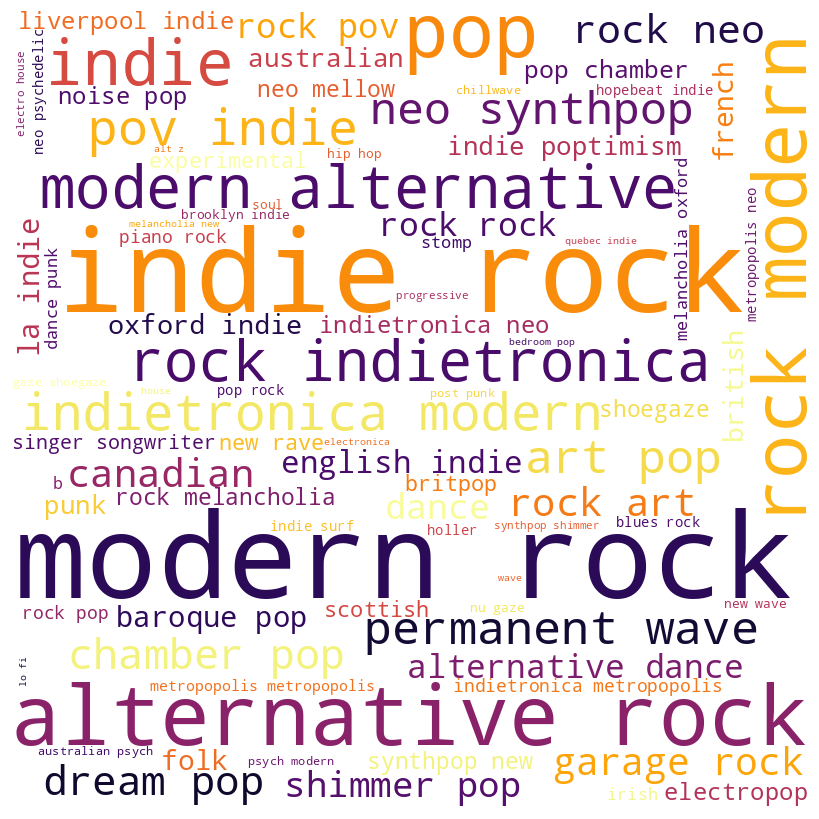

In [15]:
all_genres = ' '.join([genre for sublist in df_tracks['genres'].dropna() for genre in sublist])

wordcloud = WordCloud(width = 800, height = 800,
                      background_color ='white', 
                      colormap='inferno',  
                      min_font_size = 10).generate(all_genres)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

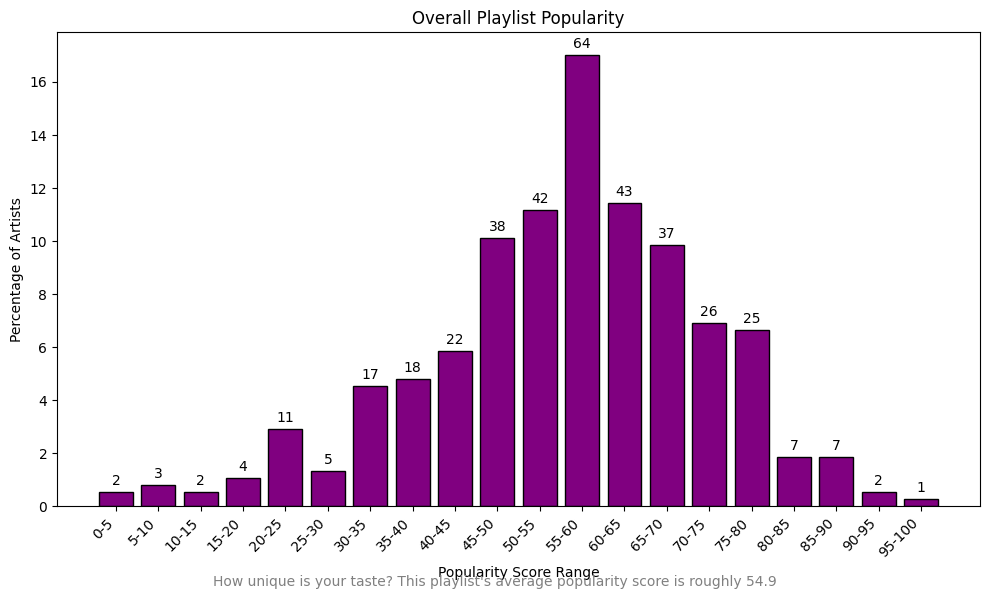

In [16]:
def plotPopularity(df_artists):
    bin_edges = np.arange(0, 105, 5)
    counts, _ = np.histogram(df_artists['popularity'], bins=bin_edges)
    percentages = (counts / df_artists['popularity'].count()) * 100
    avg_popularity = df_artists['popularity'].mean()

    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(range(len(bin_edges)-1), percentages, color='purple', edgecolor='black')
    for bar, count in zip(bars, counts):
        if count !=0:
            ax.annotate(f'{count}', 
                        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                        xytext=(0, 3),  
                        textcoords="offset points",
                        ha='center', va='bottom')

    ax.set_xticks(range(len(bin_edges)-1))
    ax.set_xticklabels([f'{bin_edges[i]}-{bin_edges[i+1]}' for i in range(len(bin_edges)-1)], rotation=45, ha="right")

    ax.set_xlabel('Popularity Score Range')
    ax.set_ylabel('Percentage of Artists')
    ax.set_title('Overall Playlist Popularity')

    caption = f"How unique is your taste? This playlist's average popularity score is roughly {avg_popularity:.1f}"
    fig.text(0.5, 0.01, caption, ha='center', va='bottom', fontsize=10, color='gray')

    plt.tight_layout()
    plt.show()
    
plotPopularity(df_artists)

In [17]:
def plotgenreDiversity(df_artists):
    all_genres = set()
    for genres in df_artists['genres']:
        all_genres.update(genres)
    total_unique_genres = len(all_genres)
    
    # Prep data for the top 10 artists by genre count.
    df_artists['genre_count'] = df_artists['genres'].apply(len)
    top_artists = df_artists.nlargest(10, 'genre_count')
    
    source = ColumnDataSource(data=dict(
        names=top_artists['name'],
        counts=top_artists['genre_count'],
        genres=['; '.join(genres) for genres in top_artists['genres']]
    ))
    
    p = figure(x_range=top_artists['name'], height=400, title="Top 10 Artists by Genre Diversity",
               toolbar_location=None, tools="")
    p.vbar(x='names', top='counts', width=0.9, source=source, legend_field="names", 
           line_color='white', fill_color='purple')
    
    p.add_tools(HoverTool(tooltips=[("Artist", "@names"), ("# Genres", "@counts"), ("Genres", "@genres")]))
    
    p.xaxis.major_label_orientation = "vertical"
    p.xgrid.grid_line_color = None
    p.y_range.start = 0
    
    caption_text = f'<div><strong>Total Unique Genres in Playlist: {total_unique_genres}</strong></div>'
    caption = Div(text=caption_text)
    layout = column(p, caption)
    
    output_notebook() 
    show(layout)
    
plotgenreDiversity(df_artists)

Loading BokehJS ...

/var/folders/m7/8cp5z4310hqb937r9shcwp680000gn/T/ipykernel_27381/2944227424.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tracks['release_year'] = pd.to_datetime(df_tracks['release_date']).dt.year


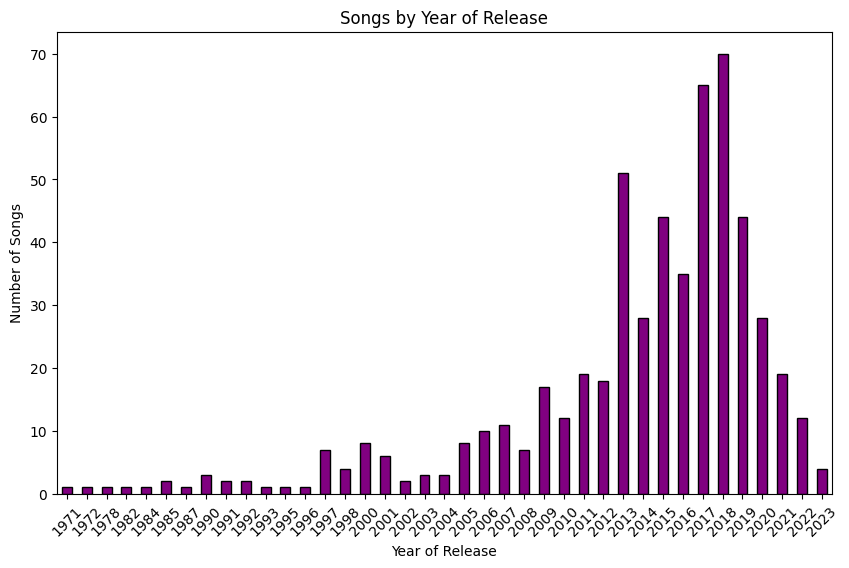

In [18]:
def plotRelease(df_tracks):
    #filter out poorly formatted dates
    df_tracks = df_tracks[df_tracks['release_date'].str.len()==10]
    df_tracks['release_year'] = pd.to_datetime(df_tracks['release_date']).dt.year
    tracks_by_year = df_tracks['release_year'].value_counts().sort_index()
    plt.figure(figsize=(10, 6))
    tracks_by_year.plot(kind='bar', color='purple', edgecolor='black') 
    plt.xlabel('Year of Release')
    plt.ylabel('Number of Songs')
    plt.title('Songs by Year of Release')
    plt.xticks(rotation=45)
    plt.show()

plotRelease(df_tracks)

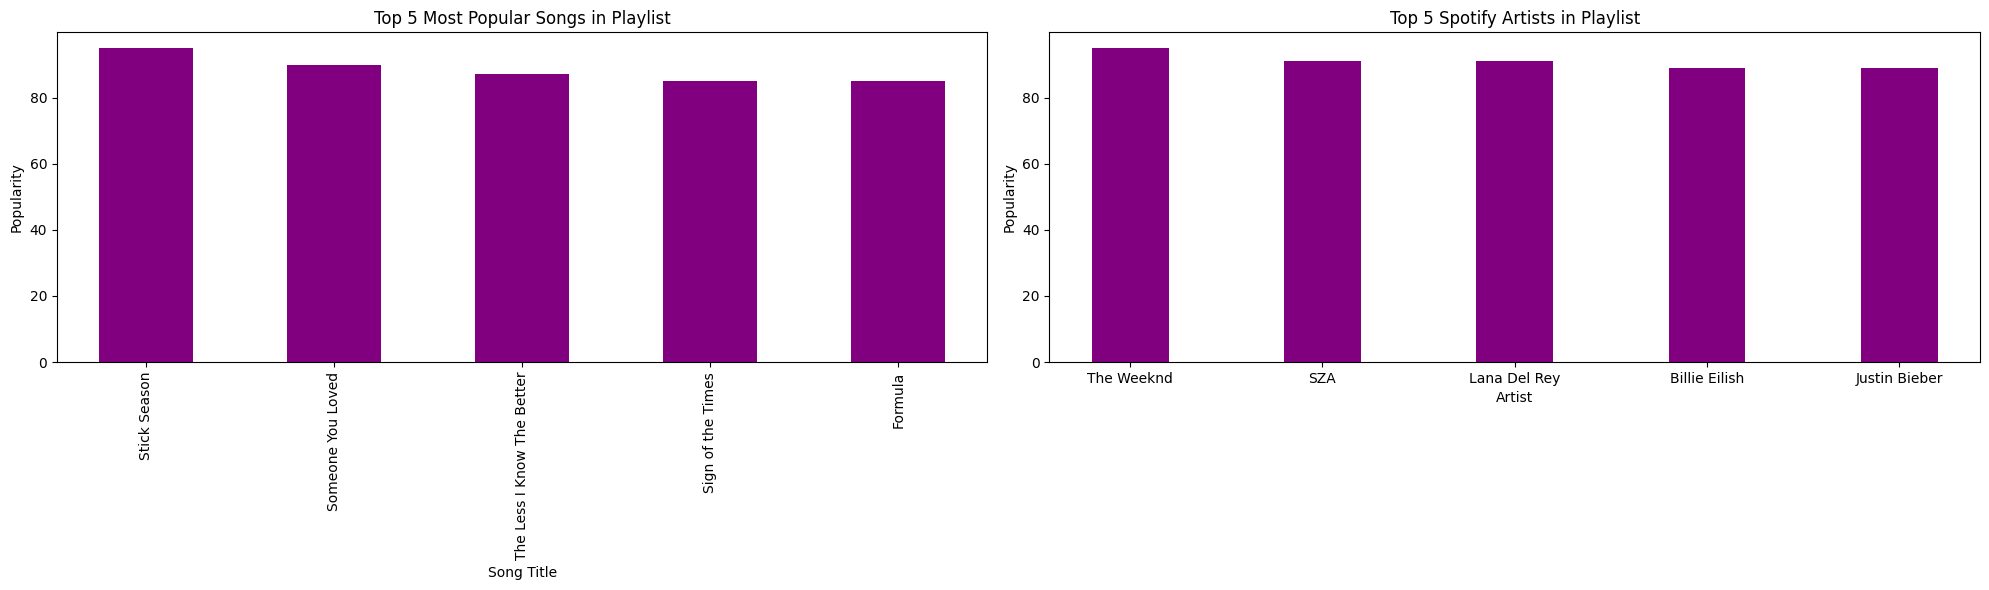

Time elapsed: 0.5420960000000008 s


In [19]:
def plotTopofPlaylist(df_tracks, artists_df):
    fig, axs = plt.subplots(1, 2, figsize=(20, 6)) 

    top_5_songs = df_tracks.sort_values(ascending=False, by='popularity')[:5]
    axs[0].bar(top_5_songs['title'], top_5_songs['popularity'], color='purple', width=0.5)
    axs[0].set_title('Top 5 Most Popular Songs in Playlist')
    axs[0].set_xlabel('Song Title')
    axs[0].set_ylabel('Popularity')
    axs[0].tick_params(axis='x', rotation=90)

    top_5_artists = artists_df.sort_values(ascending=False, by='popularity')[:5]
    axs[1].bar(top_5_artists['name'], top_5_artists['popularity'], color='purple', width=0.4)
    axs[1].set_title('Top 5 Spotify Artists in Playlist')
    axs[1].set_xlabel('Artist')
    axs[1].set_ylabel('Popularity')
    
    plt.tight_layout()
    plt.show()

t = time.process_time()
plotTopofPlaylist(df_tracks, df_artists)
elapsed_time = time.process_time() - t
print('Time elapsed:', elapsed_time, 's')

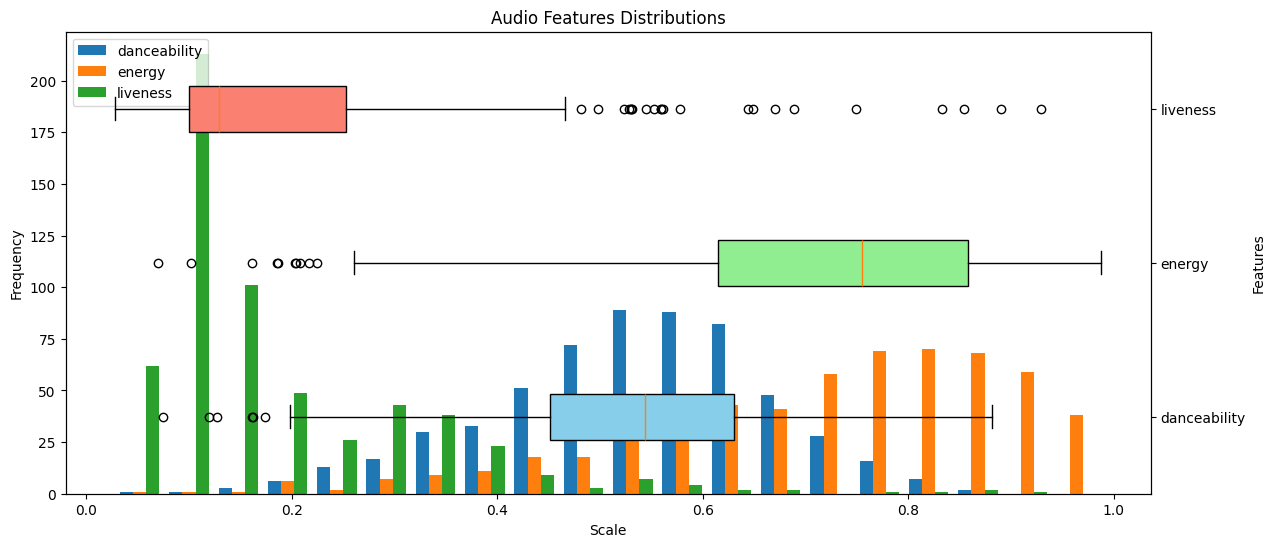

In [20]:

def plotAudioFeatures(df_audio_features):
    features = ['danceability', 'energy', 'liveness']
    data = [df_audio_features[feature] for feature in features]
    
    colors = ['skyblue', 'lightgreen', 'salmon']
    
    fig, ax1 = plt.subplots(figsize=(14, 6))
    # plt.style.use('seaborn-deep')

    ax1.hist(data, bins=20, label=features)
    ax1.set_xlabel("Scale")
    ax1.set_ylabel("Frequency")
    ax1.legend(loc='upper left')
    
    ax2 = ax1.twinx()
    
    box = ax2.boxplot(data, vert=False, positions=np.arange(len(data)) + 1, patch_artist=True)
    
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    
    ax2.yaxis.tick_right()
    ax2.set_yticks(np.arange(1, len(data) + 1))
    ax2.set_yticklabels(features)
    ax2.yaxis.set_label_position("right")
    ax2.set_ylabel("Features")

    plt.title("Audio Features Distributions")
    plt.show()

plotAudioFeatures(df_audio_features)

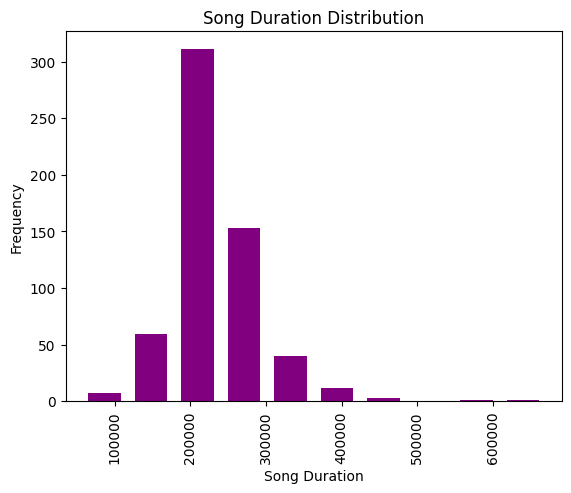

Time elapsed: 0.23824700000000032 s


In [21]:
def plotDuration(df_audio_features):
    plt.hist(df_audio_features.duration_ms, color='purple', rwidth=0.7)
    plt.xlabel("Song Duration")
    plt.xticks(rotation=90)
    plt.ylabel("Frequency")
    plt.title("Song Duration Distribution")
    plt.show()

t = time.process_time()
plotDuration(df_audio_features)
elapsed_time = time.process_time() - t
print('Time elapsed:', elapsed_time,'s')

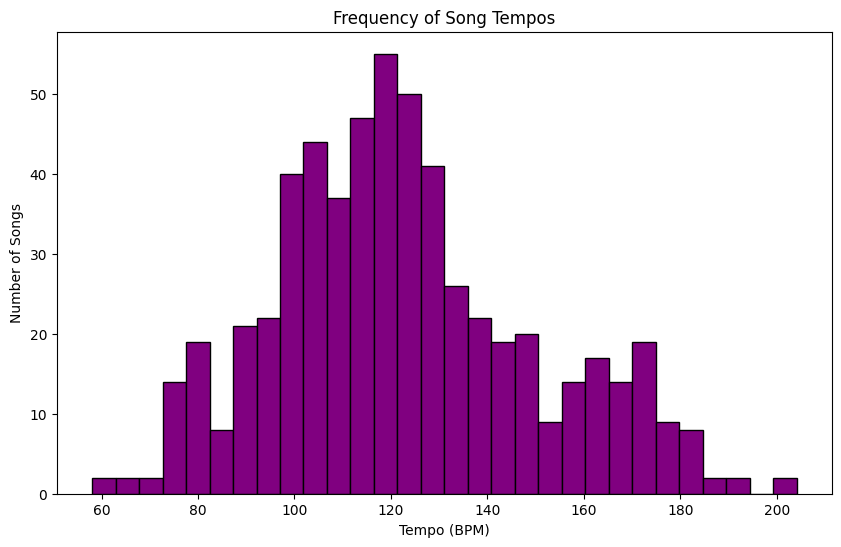

In [22]:
def plotTempo(df_audio_features):
    plt.figure(figsize=(10, 6))
    plt.hist(df_audio_features['tempo'], bins=30, color='purple', edgecolor='black')
    plt.xlabel('Tempo (BPM)')
    plt.ylabel('Number of Songs')
    plt.title('Frequency of Song Tempos')
    plt.show()

plotTempo(df_audio_features)

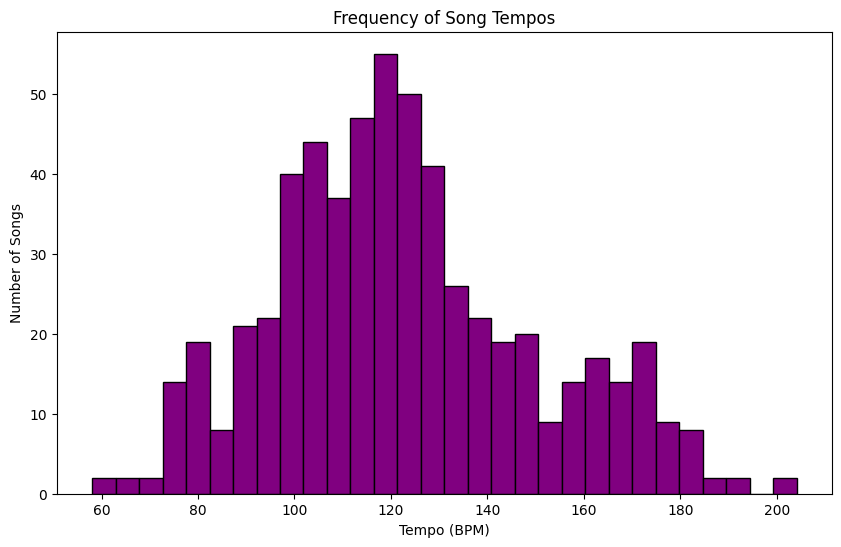

         266968 function calls (259036 primitive calls) in 0.433 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.061    0.061    0.061    0.061 {method 'encode' of 'ImagingEncoder' objects}
     3394    0.015    0.000    0.015    0.000 {method 'reduce' of 'numpy.ufunc' objects}
      208    0.010    0.000    0.056    0.000 text.py:358(_get_layout)
       55    0.007    0.000    0.007    0.000 {method 'set_text' of 'matplotlib.ft2font.FT2Font' objects}
3651/3039    0.007    0.000    0.039    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
     3095    0.006    0.000    0.006    0.000 {method 'copy' of 'numpy.ndarray' objects}
     8526    0.005    0.000    0.012    0.000 {built-in method builtins.getattr}
     1343    0.005    0.000    0.007    0.000 font_manager.py:638(__hash__)
       96    0.004    0.000    0.034    0.000 ticker.py:2077(_raw_ticks)
  2353/39    0.004    0.000  

In [23]:
#look for bottlenecks once we have the finalized code
%prun plotTempo(df_audio_features)

All together now

                       id        name  tracks_total
0  7qkgBK0HyIl7KGA0Z0wK7F  Adv_Python             3
                        id                                              title  \
0   33CehYfkie4ugV2gWaTKlM                                        Sleep Alone   
1   3EbDjzynYszfKEbCzQLA22                                          Hyperlips   
2   4iG2gAwKXsOcijVaVXzRPW                                    Time to Pretend   
3   0MVE8I80hHgzidIMT0wghI                                 Your Life Is a Lie   
4   5esEbMt6LHtiha7cqsGdO7                                     Flash Delirium   
5   2PjDWdGvvbLQfRRTQIZPmv                                         Speechless   
6   4ye3W4xNyQkIItKp01QbLM                                  Dance In The Dark   
7   7IPohgbTZLBDewkxMaWok7                               So Happy I Could Die   
8   6PUIzlqotEmPuBfjbwYWOB  Summertime Sadness (Lana Del Rey Vs. Cedric Ge...   
9   2lFTzUnuGaWlWHJQokjRyb                                         Blue Jeans   
10  7

Loading BokehJS ...

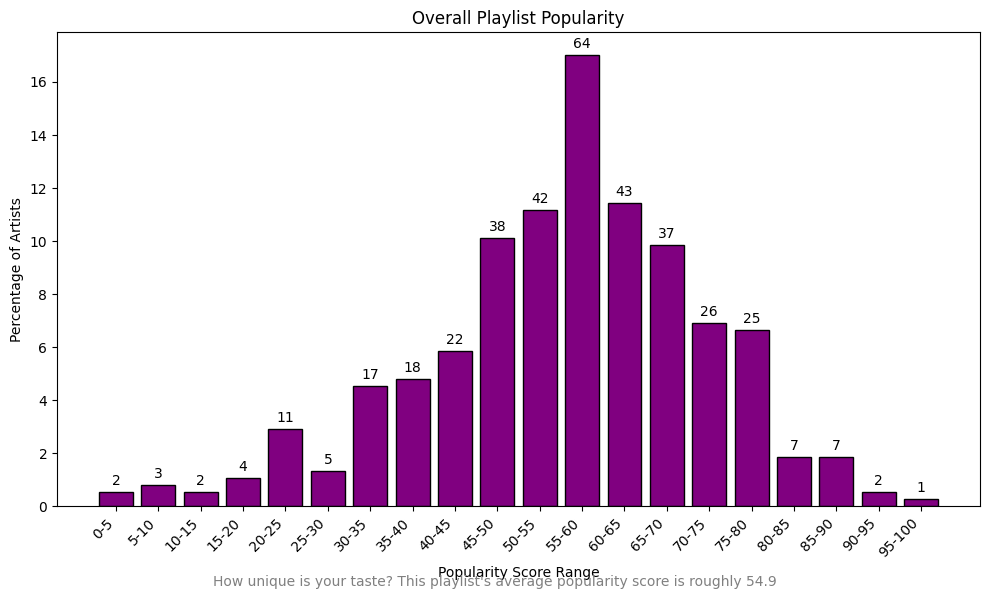

Loading BokehJS ...

/var/folders/m7/8cp5z4310hqb937r9shcwp680000gn/T/ipykernel_27381/2944227424.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tracks['release_year'] = pd.to_datetime(df_tracks['release_date']).dt.year


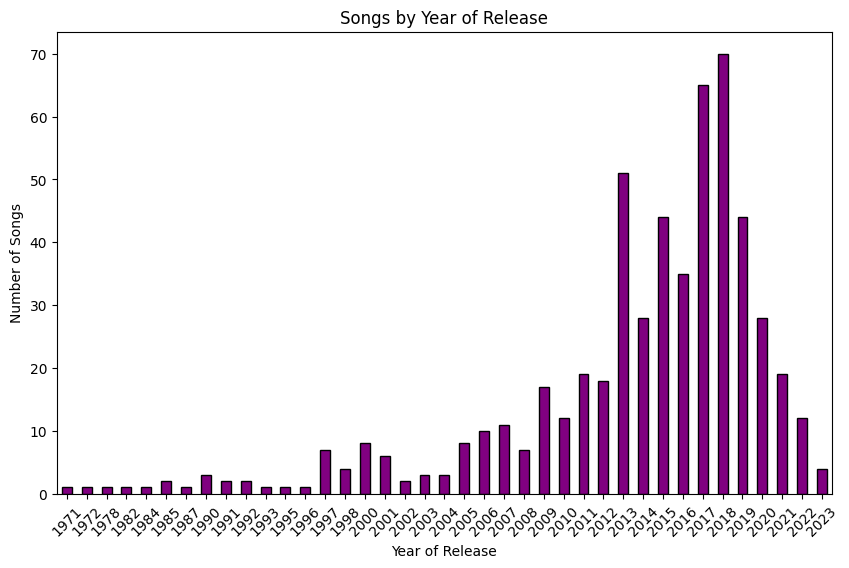

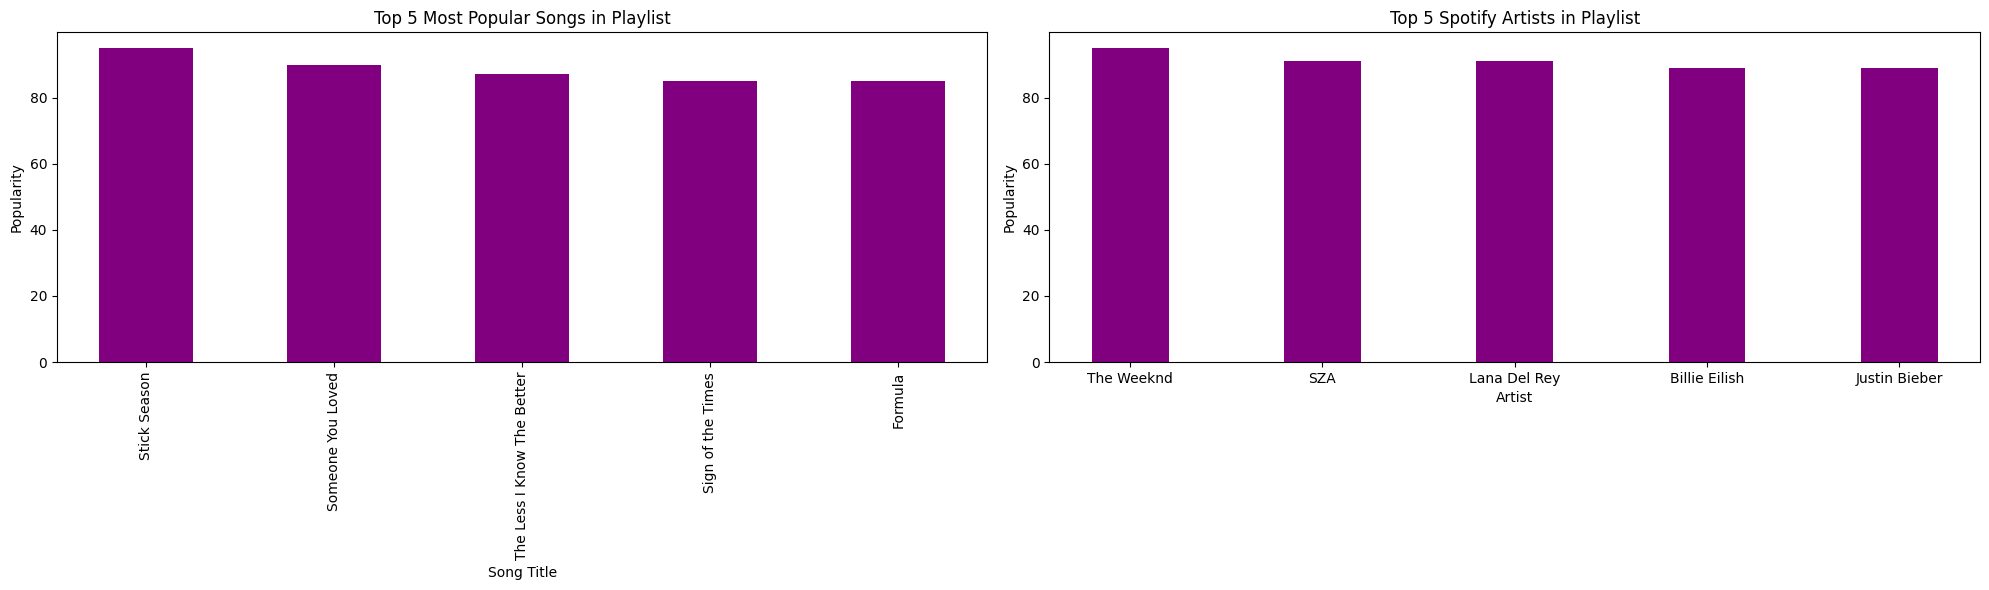

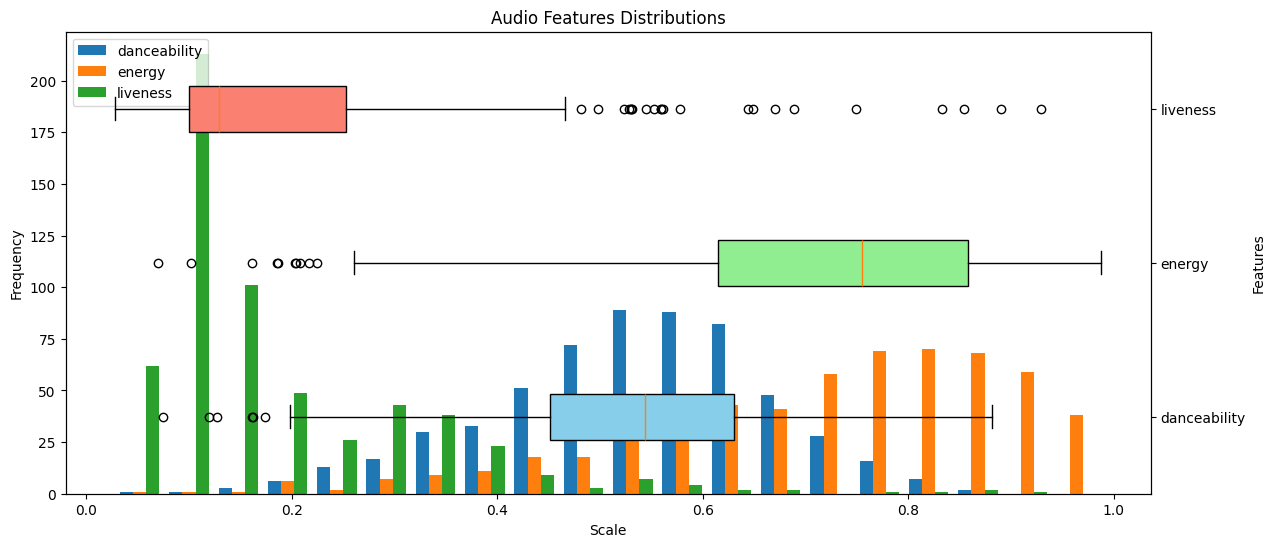

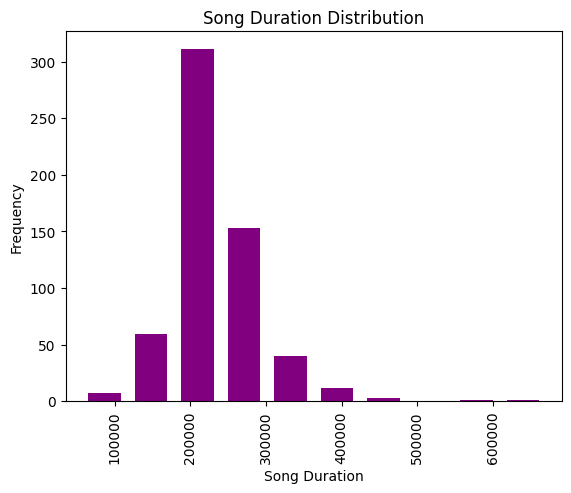

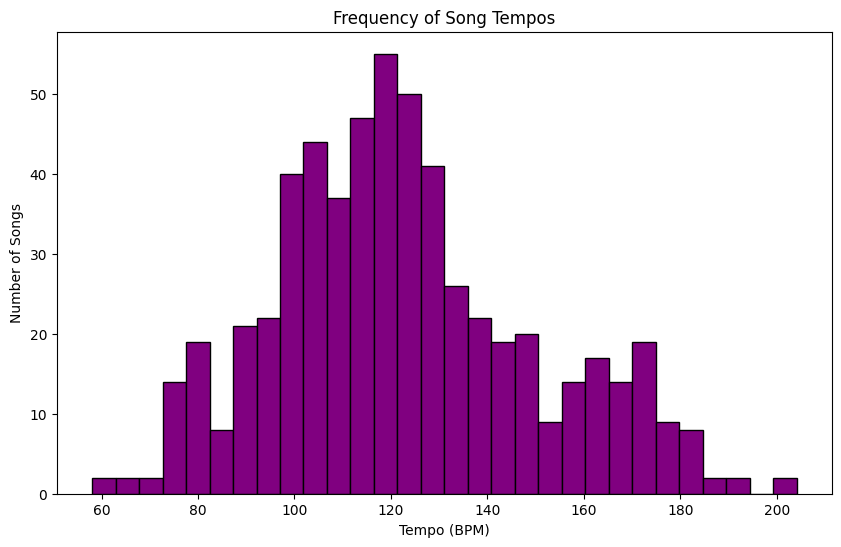

         3223342 function calls (3108680 primitive calls) in 16.066 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      262    9.889    0.038    9.889    0.038 {method 'read' of '_ssl._SSLSocket' objects}
       22    0.740    0.034    0.740    0.034 {method 'do_handshake' of '_ssl._SSLSocket' objects}
       22    0.597    0.027    0.597    0.027 {method 'connect' of '_socket.socket' objects}
        6    0.491    0.082    0.491    0.082 {method 'encode' of 'ImagingEncoder' objects}
       22    0.264    0.012    0.264    0.012 {method 'load_verify_locations' of '_ssl._SSLContext' objects}
    31073    0.133    0.000    0.133    0.000 {method 'reduce' of 'numpy.ufunc' objects}
     7104    0.131    0.000    0.134    0.000 transforms.py:182(set_children)
     2293    0.109    0.000    0.598    0.000 text.py:358(_get_layout)
      596    0.087    0.000    0.087    0.000 {method 'set_text' of 'matplotlib.ft2font.FT2Font' ob

In [24]:
def playlist_analyzer():
    access_token = getAuth()
    user_playlists = getPlaylists(access_token)
    tmp_df = dfPlaylists(user_playlists)
    playlists_original_df = getColumns(tmp_df,['id','name', 'tracks_total'])
    # See playlist details.
    print(playlists_original_df.head(20))
    # See track details from indicated playlist.
    playlist = getPlaylist('1yAVZk9EiKCBkdndqpUDXk', access_token)
    df_tracks = dfPlaylist(playlist)
    print(df_tracks.head(20))
    # artists
    artists = getArtist(list(df_tracks.artist_id), access_token) 
    df_artists = artistDf(artists)
    print(df_artists.head(100))
    # Add genres (artist level, pulled from df_artist) to df_tracks for easier data accessibility.
    df_tracks = genretoPlaylist(df_tracks, df_artists)
    print(df_tracks.head())
    # View audio features of relevant tracks in playlist.
    audio_features = getAudiosFeatures(list(df_tracks.id), access_token)
    df_audio_features = audioFeaturesDf(audio_features)
    print(df_audio_features.head(100))
    # plots - add function for word cloud
    plotTopGenres(df_artists)
    plotPopularity(df_artists)
    plotgenreDiversity(df_artists)
    plotRelease(df_tracks)
    plotTopofPlaylist(df_tracks, df_artists)
    plotAudioFeatures(df_audio_features)
    plotDuration(df_audio_features)
    plotTempo(df_audio_features)

# t = time.process_time()
# playlist_analyzer()
# elapsed_time = time.process_time() - t
# print('Time elapsed:', elapsed_time,'s')
%prun playlist_analyzer()